In [1]:
import numpy as np
import seaborn as sb
import json
import pandas as pd
import nltk
from nltk.tokenize import TreebankWordTokenizer,sent_tokenize
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import re, pickle
import contractions as con
from string import punctuation
from collections import Counter

tk = TreebankWordTokenizer()

In [2]:
# load datasets

reddit = pd.read_csv('/home/bibek/Downloads/reddit.csv',encoding='latin-1').full_text
imdb_reviews = pd.read_csv('IMDB Dataset.csv').review
movie_plots = pd.read_csv('wiki_movie_plots_deduped.csv',encoding='latin-1').Plot
twitter = pd.read_csv('/home/bibek/notebooks/tweet_16.csv',encoding='latin-1')
twitter = twitter[twitter.columns[-1]]

text = []

text.extend(reddit)
text.extend(movie_plots)
text.extend(imdb_reviews)
text.extend(twitter)

len(text)

1748912

In [3]:
def preprocess_text(x):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','')
    x = x.lower()
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x).split()
    for i,w in enumerate(x):
        if '@' in w:
            x[i] = 'USER'
    x = ' '.join(x)
    punct_to_keep = """!,.:#?"-;//%$'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    return x



In [4]:
np.random.shuffle(text)

In [5]:
# sample cleaned text

idx = np.random.randint(0,len(text) - 1,10)

for i in idx:
    print(text[i])
    print()
    print(preprocess_text(text[i]))
    print('-----------------------------------------------')

http://tinyurl.com/abc8vc why bebi gib sad song 

LINK why bebi gib sad song
-----------------------------------------------
@shaundiviney why cant bradie chatttt tooo 

USER why cant bradie chatttt tooo
-----------------------------------------------
@EggSoup www.Shakeology.com  

USER LINK
-----------------------------------------------
WOAH, its a fkin tsunami goin on outside.. proper heavy rain!!! 

woah , its a fkin tsunami goin on outside . proper heavy rain !
-----------------------------------------------
@YoMma will B editing the latest MicroWarpCast show which we recorded 2 weeks ago but I couldn't find the time 2 edit do 2 RL obligations 

USER will b editing the latest microwarpcast show which we recorded 2 weeks ago but i couldn't find the time 2 edit do 2 rl obligations
-----------------------------------------------
Hmm I really fancy watching an Ancient Egypt documentary. ANYTHING BUT REVISION 

hmm i really fancy watching an ancient egypt documentary . anything but rev

In [6]:
# clean text

clean_text = [preprocess_text(x) for x in tqdm(text)]

  0%|          | 0/1748912 [00:00<?, ?it/s]

In [8]:
# load pretrained tokenizer

from bpe_tokenizer import BPETokenizer

if __name__ == "__main__":

    with open('tokenizer.pkl','rb') as f:
        tokenizer = pickle.load(f)

In [9]:
# split long sequence in smaller ones and store the data

def split_long_text(text,maxlen=200):
    sents = sent_tokenize(text)
    tmp = []
    sent = ''
    for s in sents:
        if len((s + sent).split()) <= maxlen:
            if s.split()[-1] not in punctuation:
                sent = sent + s + '.'
            else:
                sent = sent + s
            sent = sent.strip()
            sent = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', sent)
            re.sub(r'\s+', ' ', sent)
        else:
            sent = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', sent)
            tmp.append(sent)
            sent = s
    
    sent = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', sent)
    sent = re.sub(r'\s+', ' ', sent)
    tmp.append(sent)
    
    return tmp
    


text_data = []

for text in tqdm(clean_text):
    if len(text.split()) >= 30:
        splitted_text = split_long_text(text,maxlen=100)
        text_data.extend(splitted_text)
    
    
print('number of sequences :',len(text_data))

  0%|          | 0/1748912 [00:00<?, ?it/s]

number of sequences : 466991


In [10]:
# tokenize sequences

token_seq = []

for seq in tqdm(text_data):
    seq = seq.strip()
    seq = '<cls> ' + seq + ' <sep>'
    seq = tokenizer.tokenize(seq)
    token_seq.append(seq)

  0%|          | 0/466991 [00:00<?, ?it/s]

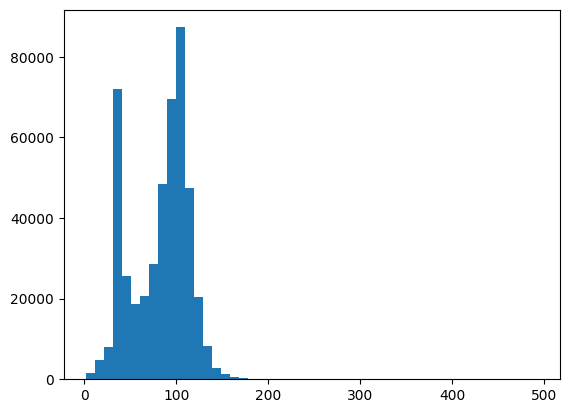

In [11]:
# visualize token count in sequences

plt.hist([len(x) for x in token_seq],bins=50)
plt.show()

In [12]:
# keep sequences with only minlen 50 and maxlen 128

token_seq = [x for x in token_seq if 50 <= len(x) <= 128]

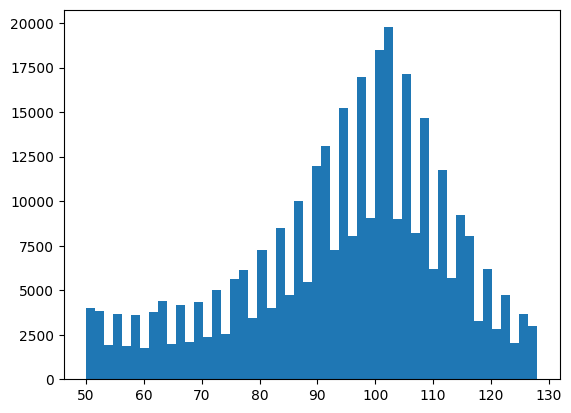

In [13]:
plt.hist([len(x)for x in token_seq],bins=50)
plt.show()

In [14]:
# sample subword-split

idx = np.random.randint(0,len(text_data),10)


for i in idx:
    seq = text_data[i].split()
    sent = re.sub(r'\s+', ' ', text_data[i])
    seq = ' '.join([tokenizer._split_oov(x) for x in seq])
    print(sent)
    print('-------------------------------------------------------')
    print(seq)
    print('=========================================================')

the disturbed miss robey ends up setting fire to the house , whereupon mark redeems himself in celia 's eyes by saving her life . 
-------------------------------------------------------
the disturbed miss robe ## y ends up setting fire to the house , whereupon mark redeems himself in celia 's eyes by saving her life .
waldo agrees after father volunteers to stay inside the library as a hostage . coalhouse 's supporters escape in the car , and he drives father out the library . he prays , seeming ready to blow himself up , but instead surrenders to the police . as he steps out of the building with his hands raised , waldo orders a sniper to shoot him . coalhouse stumbles a short distance and falls dead . the film ends with another newsreel montage : evelyn dances in vaudeville , and harry thaw is released from an asylum . 
-------------------------------------------------------
waldo agrees after father volunteers to stay inside the library as a hostage . coal ## house 's supporters es

In [15]:
# pad sequences

token_seq = np.asarray([tokenizer.add_padding(seq,maxlen=128) for seq in token_seq])

In [18]:
def create_masked_data(seq,vocab_size,for_train=True,dont_mask_toks=np.asarray([2,0,4,5],np.int32)):
    
    # mask random tokens
    seq = np.asarray(seq,dtype=np.int32)
    end = np.where(seq == 2)[0][0]
    masked_seq = seq.copy()
    n_mask = int(len(np.where(seq>0)[0])*0.12)
    mask = ~np.isin(seq, dont_mask_toks)
    to_mask_idx = np.where(mask)[0]
    to_mask_prob = n_mask/len(to_mask_idx)
    probs = np.linspace(0,1,len(to_mask_idx))
    np.random.shuffle(probs)
    to_mask = masked_seq[to_mask_idx].copy()
    to_mask = np.where(probs>=to_mask_prob,to_mask,1)
    masked_seq[to_mask_idx] = to_mask
    masked_idx = np.where(masked_seq == 1)[0]
    
    # create inverse mask
    inv_mask = np.zeros(len(seq),dtype=np.int32)
    inv_mask[masked_idx] = seq[masked_idx]
    
    # replace 1% of tokens with random tokens (only for training data) 
    if for_train:
        non_masked_idx = np.where(masked_seq > 1)[0]
        num_tok_to_replace = int((len(seq) - 2) * 0.015)
        rand_idx = non_masked_idx[np.random.randint(0,len(non_masked_idx)-1,num_tok_to_replace)]
        rand_replacements = np.random.randint(6,vocab_size,num_tok_to_replace)
        masked_seq[rand_idx] = rand_replacements
        
    return seq,masked_seq

i = np.random.randint(0,len(token_seq))
create_masked_data(token_seq[i],len(tokenizer.i2w),for_train=True)

(array([    4,    37,  5806,  3525,     5,  7766,  6576,   170,     7,
          959,     5,  1687,     5,   486,    12,     6,  1343, 14153,
         4122,  3780,   214, 19946,     6,   288,    10,  4122,  1218,
        19947,  5684, 19950,  4498, 19950,  4808,     5,   324,     5,
          836,   640,     5,  1489,     5,  7421, 19947,   165,    14,
           16,   912,     7,  9805,     6, 12939,     5,  7766, 19946,
          133, 19947,    78,  4498,    11,  7893,    88, 19949, 17213,
            8, 11102,    12,    16,   155,   430, 19947,    12,   921,
           18,   533,     7,    36,    37,  3053,  6252,  2463,    17,
         8851, 13155, 19947,   875,  6406, 17394,     5, 10036,  7042,
            8, 10799,  1345,   387,     5, 13748,     5,    24, 19947,
         1913,     5,    15,     5, 16191,     5,   936, 15496,    57,
         9054,     5,  5283,     5,  5724,     5,     9, 19947,  8227,
        19947,     8, 19215,     8, 11619,   545, 19946,     2,     0,
      

In [19]:
# sample masking

seq,masked = create_masked_data(token_seq[i],len(tokenizer.i2w),for_train=True)

print(' '.join([tokenizer.i2w[t] for t in seq if t != 0]))
print()
print(' '.join([tokenizer.i2w[t] for t in masked if t != 0]))
print()
idx = np.where(masked == 1)[0]
print(' '.join([tokenizer.i2w[t] for t in seq[idx] if t != 0]))

<cls> an anonymous flash ## er exposes himself to shop ## per ## s in the forest ridge mall parking lot . the head of mall security , ronald " ronnie " barn ## hard ## t r ## o ## gen , makes it his mission to apprehend the offend ## er . however , while ronnie is ostensibly well - intentioned and valiant in his own mind , in reality he appears to be an emotionally unstable individual with vigilante tendencies , apparently experiencing bi ## polar disorder and displaying violent idea ## ti ## on , grand ## i ## os ## e delusions or mega ## lo ## mani ## a , paranoia , and bigoted and delusional thinking . <sep>

<cls> <mask> anonymous flash ## er <mask> himself to shop ## per ## s <mask> the forest <mask> mall parking lot . the head of mall security , ronald " ronnie " barn ## hard ## t r ## <mask> ## gen , makes it <mask> mission <mask> apprehend the offend ## rites . however , while ronnie is ostensibly well - intentioned and valiant in his own mind <mask> in <mask> he <mask> to be <

In [20]:
# dictionary for storing train and val sets

pretraining_data = {'train':{'seq':[],'masked_seq':[]},
                    'valid':{'seq':[],'masked_seq':[]}}

In [21]:
np.random.shuffle(token_seq)

In [22]:
# split train and val ( val data is 60k sequences)

train,valid = [],[]
size = len(tokenizer.i2w)
val_size = 60000

for i,seq in enumerate(token_seq):
    
    if i >= val_size:
        seq,masked_seq = create_masked_data(seq,size,for_train=True)
        if len(seq) > 0:
            train.append((seq,masked_seq))
        
    else:
        seq,masked_seq = create_masked_data(seq,size,for_train=False)
        if len(seq) > 0:
            valid.append((seq,masked_seq))

In [23]:
np.random.shuffle(train)
np.random.shuffle(valid)   

len(train),len(valid)

(281978, 60000)

In [24]:
# store train and val sets

for seq,masked in train:
    pretraining_data['train']['masked_seq'].append(masked)
    pretraining_data['train']['seq'].append(seq)
    
for seq,masked in valid:
    pretraining_data['valid']['masked_seq'].append(masked)
    pretraining_data['valid']['seq'].append(seq)

In [25]:
# data and tokenizer

with open('pretraining data.pkl','wb') as f:
    pickle.dump(pretraining_data,f)
    
with open('tokenizer.pkl','wb') as f:
    pickle.dump(tokenizer,f)